# 14. 나이브 베이즈 분류

In [2]:
library(bayesrules)
library(tidyverse)
library(e1071)
library(janitor)

In [4]:
data(penguins_bayes)
penguins <- penguins_bayes

In [5]:
penguins %>% 
  tabyl(species)

species,n,percent
<fct>,<int>,<dbl>
Adelie,152,0.4418605
Chinstrap,68,0.1976744
Gentoo,124,0.3604651


In [7]:
penguins %>% head

species,island,year,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,above_average_weight,sex
<fct>,<fct>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>
Adelie,Torgersen,2007,39.1,18.7,181,3750,0,male
Adelie,Torgersen,2007,39.5,17.4,186,3800,0,female
Adelie,Torgersen,2007,40.3,18.0,195,3250,0,female
Adelie,Torgersen,2007,NA,NA,NA,NA,NA,NA
Adelie,Torgersen,2007,36.7,19.3,193,3450,0,female
Adelie,Torgersen,2007,39.3,20.6,190,3650,0,male


<br>

## 14.01. 나이브 베이즈 분류

### (1) 범주형 설명변수를 통한 분류

#### 범주별 `above_average_weight`의 비율 $\rightarrow$ `chinstrap`종이 `above_average_weight`의 비율이 낮음
#### 하지만 `chinstrap`종이 전체 관측값 중 가장 출현 비율이 낮음

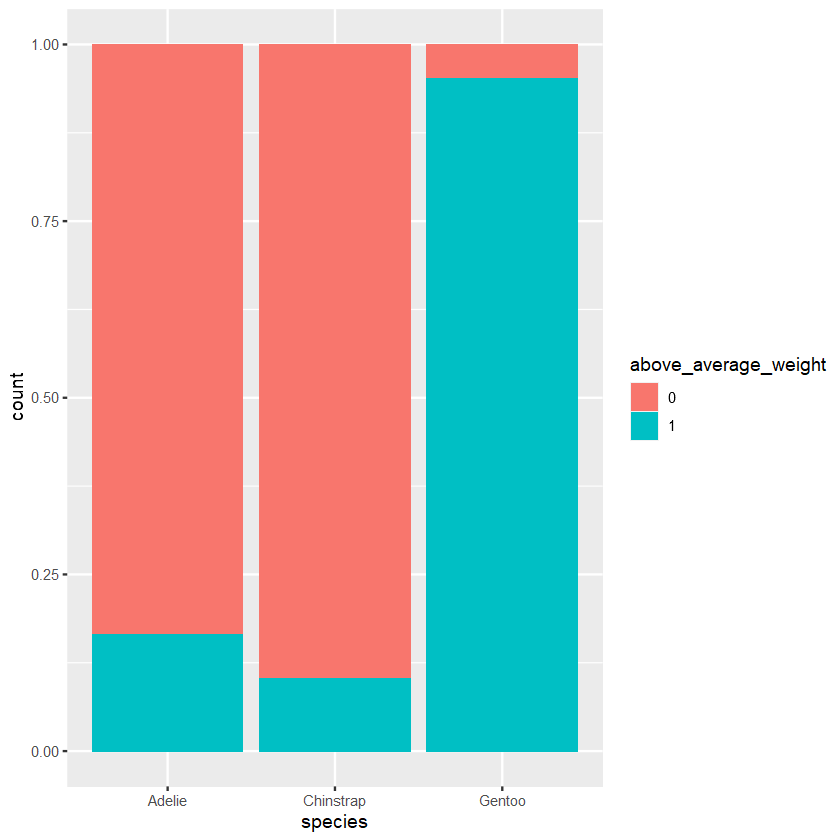

In [6]:
ggplot(penguins %>% drop_na(above_average_weight), 
       aes(fill = above_average_weight, x = species)) + 
  geom_bar(position = "fill")

<br>

#### 이러한 종별 비율과, 종별 `above_average_weight`의 비율을 고려하여
$$\begin{equation}
f(y \; | \; x_1) = \frac{\text{ prior} \cdot \text{likelihood}}{\text{ normalizing constant }} = \frac{f(y)L(y \; | \;  x_1)}{f(x_1)}
\end{equation}$$이며 $f(x_1)$은

$$\begin{equation}
\begin{split}
f(x_1) 
& = \sum_{\text{all } y'} f(y')L(y' \; | \;  x_1) \\
& = f(y' = A)L(y'=A|x_1) + f(y' = C)L(y'=C|x_1) + f(y' = G)L(y'=G|x_1).\\ 
\end{split}
\end{equation}$$

<br>

In [11]:
penguins %>% 
  select(species, above_average_weight) %>% 
  na.omit() %>% 
  tabyl(species, above_average_weight) %>% 
  adorn_totals(c("row", "col"))

,species,0,1,Total
,<fct>,<dbl>,<dbl>,<dbl>
1,Adelie,126,25,151
2,Chinstrap,61,7,68
3,Gentoo,6,117,123
4,Total,193,149,342


<br>

#### 각 종별 비율
$$\begin{equation}
f(y = A) = \frac{151}{342}, \;\;\;\;\; 
  f(y = C) = \frac{68}{342}, \;\;\;\;\; 
  f(y = G) = \frac{123}{342}
\end{equation}$$

#### **을 고려한 $above\_average\_weight=0$에 대한 가능도는**

$$\begin{split}
L(y = A \; | \; x_1 = 0) & = \frac{126}{151} \approx 0.8344 \\
L(y = C \; | \; x_1 = 0) & = \frac{61}{68}   \approx 0.8971 \\
L(y = G \; | \; x_1 = 0) & = \frac{6}{123}   \approx 0.0488 \\
\end{split}$$

<br>

#### 따라서, 정규화 상수는

$$f(x_1 = 0) = \frac{151}{342} \cdot \frac{126}{151} + \frac{68}{342} \cdot \frac{61}{68} + \frac{123}{342} \cdot \frac{6}{123} = \frac{193}{342}  .$$

#### **이며, $above\_average\_weight=0$일 때, 각 종 대한 사후확률은**

$$\begin{split}
f(y = A \; | \;  x_1 = 0) 
& = \frac{f(y = A) L(y = A \; | \; x_1 = 0)}{f(x_1 = 0)} \\
& = \frac{(151/342) \cdot (126/151)}{193/342} \\
& \approx 0.6528  . \\
\end{split}$$

$$f(y = C \; | \;  x_1 = 0) \approx 0.3161
\;\;\;\; \text{ and } \;\;\;\;
f(y = G \; | \;  x_1 = 0) \approx 0.0311 .$$

<br>

#### 결론적으로 한 관측값이 $above\_average\_weight=0$일 때, 종이 `Adelie`일 사후확률은 다른 종에 비해서 2배 이상 높음
- **이는 `Adelie`종에서 `above_average_weight`이 0일 비율이 타 종에 비하여 가장 낮음에도 불구하고,**

    **전체 관측값에서 `Adelie`종이 차지하는 높은 비율로 인한 결과**

<br>

### (2) 수치형 설명변수를 통한 분류

#### 종별 `bill_length_mm`의 분포

$$\begin{split}
X_2 \; | \;  (Y = A) & \sim N(\mu_A, \sigma_A^2) \\
X_2 \; | \;  (Y = C) & \sim N(\mu_C, \sigma_C^2) \\
X_2 \; | \;  (Y = G) & \sim N(\mu_G, \sigma_G^2) \\
\end{split}  .$$

Warning message:
"Removed 2 rows containing non-finite values (`stat_density()`)."


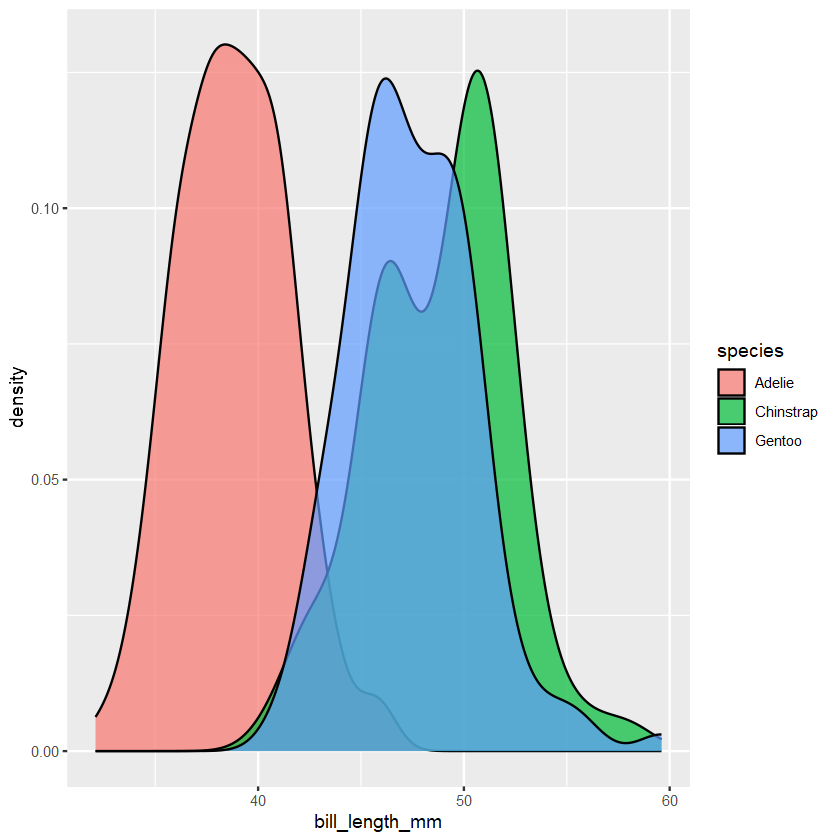

In [23]:
ggplot(penguins, aes(x = bill_length_mm, fill = species)) + 
  geom_density(alpha = 0.7) 

In [13]:
penguins %>% 
  group_by(species) %>% 
  summarize(mean = mean(bill_length_mm, na.rm = TRUE), 
            sd = sd(bill_length_mm, na.rm = TRUE))

species,mean,sd
<fct>,<dbl>,<dbl>
Adelie,38.79139,2.663405
Chinstrap,48.83382,3.339256
Gentoo,47.50488,3.081857


<br>

#### 종별 `bill_length_mm`의 평균과 표준편차를 매개변수로 가지는 정규분포 $\rightarrow$ 각 종별 `bill_length_mm`의 사전분포로 가정

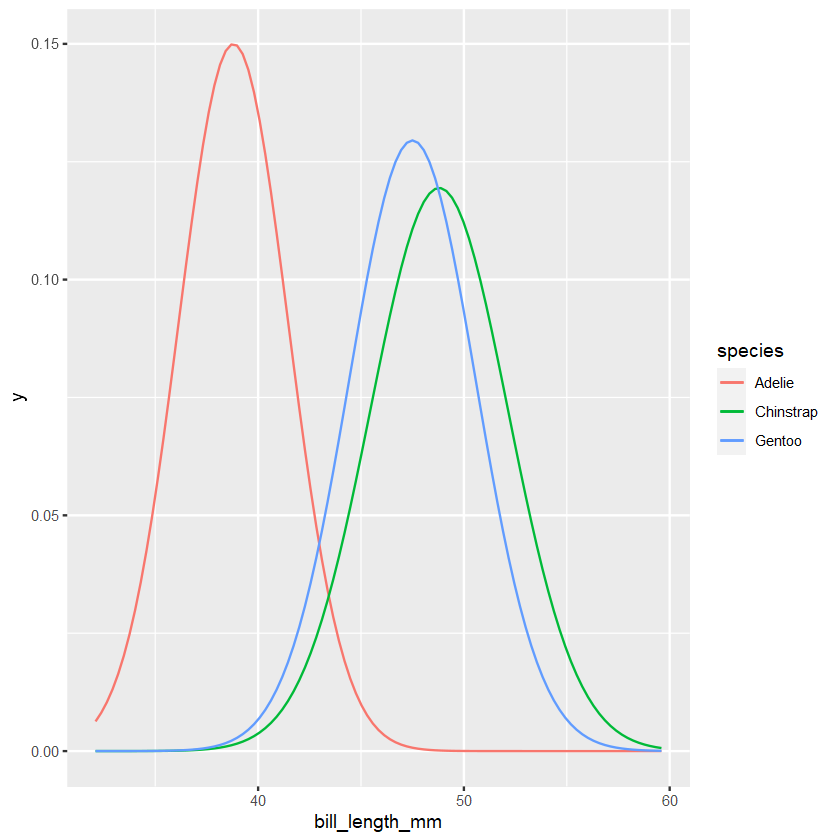

In [15]:
ggplot(penguins, aes(x = bill_length_mm, color = species)) + 
  stat_function(fun = dnorm, args = list(mean = 38.8, sd = 2.66), 
                aes(color = "Adelie")) +
  stat_function(fun = dnorm, args = list(mean = 48.8, sd = 3.34),
                aes(color = "Chinstrap")) +
  stat_function(fun = dnorm, args = list(mean = 47.5, sd = 3.08),
                aes(color = "Gentoo"))

<br>

#### 각 종별 `bill_length_mm` 사전분포의 확률밀도함수 에서, `bill_length_mm`=50일 때의 값 $\rightarrow$ 가능도 (=$L(y \; | \; x_2 = 50)$)

In [27]:
# L(y = A | x_2 = 50)
dnorm(50, mean = 38.8, sd = 2.66)

# L(y = C | x_2 = 50)
dnorm(50, mean = 48.8, sd = 3.34)

# L(y = G | x_2 = 50)
dnorm(50, mean = 47.5, sd = 3.08)

[1] 2.119955e-05

[1] 0.1119782

[1] 0.09317395

<br>

#### `bill_length_mm=50`일 때의 정규화 상수는

$$f(x_2 = 50) 
= \frac{151}{342} \cdot 0.0000212 + \frac{68}{342} \cdot 0.112 + \frac{123}{342} \cdot 0.09317
= 0.05579 .$$

#### 따라서, `bill_length_mm`=50일 때, 각 종의 사후확률

$$f(y = A \; | \;  x_2 = 50) = \frac{(151/342) \cdot 0.0000212}{0.05579} \approx 0.0002  .$$

$$f(y = C \; | \;  x_2 = 50) \approx 0.3992
\;\;\;\; \text{ and } \;\;\;\;
f(y = G \; | \;  x_2 = 50) \approx 0.6006 .$$

<br>

#### 결론적으로 한 관측값이 $bill\_length\_mm=50$일 때, 종이 `Gentoo`일 사후확률은 다른 종에 비해서 2배 가량 높음
- **이는 `Gentoo`종에서 `bill_length_mm`이 50일 떄의 확률밀도함수 값이 `Chinstrap`종에 비해 낮음에도 불구하고,** 

    **전체 관측값에서 `Gentoo`종이 차지하는 높은 비율로 인한 결과**

<br>

### (3) 여러 설명변수를 통한 분류
- **분류에 사용하는 변수가 어떤 변수이냐에 따라서, 동일한 관측값에 대해서 다른 종으로 분류할 가능성을 위에서 확인**

Warning message:
"Removed 2 rows containing non-finite values (`stat_density()`)."
Warning message:
"Removed 2 rows containing non-finite values (`stat_density()`)."


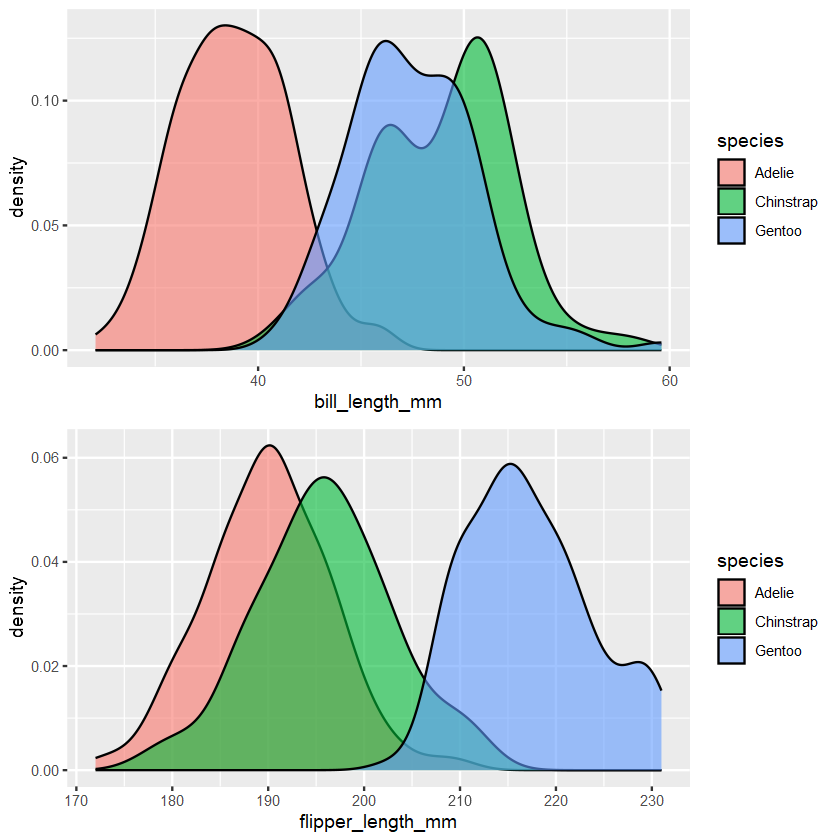

In [30]:
ggplot(penguins, aes(x = bill_length_mm, fill = species)) + 
  geom_density(alpha = 0.6) -> p1

ggplot(penguins, aes(x = flipper_length_mm, fill = species)) + 
  geom_density(alpha = 0.6) -> p2

gridExtra::grid.arrange(p1, p2)

<br>

### 나이브 베이즈 분류를 통하여, 다양한 변수에 대한 균형을 맞출 수 있음
> 반응변수 $Y$가 2개 이상의 범주를 가진 범주형 변수이고
>
> $p$개의 설명변수 $(X_1,X_2,\dots,X_p)$가 있을 때 
> 
> $(X_1,X_2,\ldots,X_p) = (x_1,x_2,\ldots,x_p)$관측값에 의하여 $Y = y$로 분류될 사후확률은
> $$f(y | x_1, x_2, \ldots, x_p) = \frac{f(y)L(y \; | \; x_1, x_2, \ldots, x_p)}{\sum_{\text{all } y' }f(y')L(y' \; | \; x_1, x_2, \ldots, x_p)}  .$$
>
> 여기서, 혼합 가능도 $L(y \; | \; x_1, x_2, \ldots, x_p)$를 계산하기 위하여, 각 설명변수별 가능도의 조건부 독립을 가정 (Naive 가정)
>
> 이는 특정한 종 내에서, 분류에 사용되는 설명변수들은 서로 독립임을 의미
> $$L(y \; | \; x_1, x_2, \ldots, x_p) = \prod_{i=1}^p f(x_i \; | \; y)\; .$$
<br>

<hr>

#### 예)

#### 한 관측값의 2개의 변수가 각각 $X_2 = x_2$, $X_3 = x_3$이라면, $Y=y$에 대한 사후분포는

$$\begin{equation}
f(y \; | \; x_2, x_3) = \frac{f(y) L(y \; | \; x_2, x_3)}{\sum_{\text{all } y'} f(y')L(y' \; | \; x_2, x_3)}  
\end{equation}$$

#### 여기서 혼합 가능도 $L(y \; | \; x_2, x_3)$를 계산하기 위하여, 
#### 각 설명변수별 가능도의 조건부 독립을 가정 (Naive 가정)

$$L(y \; | \; x_2, x_3) = f(x_2, x_3 \; | \; y) = f(x_2 \; | \; y)f(x_3 \; | \; y)  .$$

<br>

#### `flipper_length_mm`=195일 때 각 종별 가능도

In [32]:
penguins %>% 
  group_by(species) %>% 
  summarize(mean = mean(flipper_length_mm, na.rm = TRUE), 
            sd = sd(flipper_length_mm, na.rm = TRUE))

species,mean,sd
<fct>,<dbl>,<dbl>
Adelie,189.9536,6.539457
Chinstrap,195.8235,7.131894
Gentoo,217.1870,6.484976


In [33]:
# L(y = A | x_3 = 195)
dnorm(195, mean = 190, sd = 6.54)

# L(y = C | x_3 = 195)
dnorm(195, mean = 196, sd = 7.13)

# L(y = G | x_3 = 195)
dnorm(195, mean = 217, sd = 6.48)

[1] 0.04554175

[1] 0.05540502

[1] 0.0001933746

<br>

#### `bill_length_mm`=50일 때 각 종별 가능도

In [34]:
penguins %>% 
  group_by(species) %>% 
  summarize(mean = mean(bill_length_mm, na.rm = TRUE), 
            sd = sd(bill_length_mm, na.rm = TRUE))

species,mean,sd
<fct>,<dbl>,<dbl>
Adelie,38.79139,2.663405
Chinstrap,48.83382,3.339256
Gentoo,47.50488,3.081857


In [35]:
# L(y = A | x_2 = 50)
dnorm(50, mean = 38.8, sd = 2.66)

# L(y = C | x_2 = 50)
dnorm(50, mean = 48.8, sd = 3.34)

# L(y = G | x_2 = 50)
dnorm(50, mean = 47.5, sd = 3.08)

[1] 2.119955e-05

[1] 0.1119782

[1] 0.09317395

<br>

#### 나이브 베이즈 분류의, 조건부 독립 가정을 통하여
$$\begin{split}
f(y' = A)L(y' = A \; | \; x_2 = 50, x_3 = 195) & = \frac{151}{342} \cdot 0.0000212 \cdot 0.04554 \\
f(y' = C)L(y' = C \; | \; x_2 = 50, x_3 = 195) & = \frac{68}{342} \cdot 0.112 \cdot 0.05541 \\
f(y' = G)L(y' = G \; | \; x_2 = 50, x_3 = 195) & = \frac{123}{342} \cdot 0.09317 \cdot 0.0001934 \\
\end{split}$$**이며, 정규화 상수는**

$$\sum_{\text{all } y'}f(y')L(y' \; | \; x_2 = 50, x_3 = 195) \approx 0.001241  .$$

#### 따라서, 2개의 설명변수를 사용한 각 종별 사후분포는
$$f(y = A | x_2 = 50, x_3 = 195) 
= \frac{\frac{151}{342} \cdot 0.0000212 \cdot 0.04554}{0.001241} \approx 0.0003  .$$

$$\begin{split}
f(y = C | x_2 = 50, x_3 = 195) & \approx 0.9944 \\
f(y = G | x_2 = 50, x_3 = 195) & \approx 0.0052 . 
\end{split}$$

<br>

## 14.02. 나이브 베이즈 분류 구현 

<br>

#### `e1071::naiveBayes(formula, data)` : 나이브 베이즈 분류 모형 생성

In [36]:
naive_model_1 <- naiveBayes(species ~ bill_length_mm, data = penguins)
naive_model_2 <- naiveBayes(species ~ bill_length_mm + flipper_length_mm, 
                            data = penguins)

<br>

#### `bill_length_mm`=50,  `flipper_length_mm`=195인 관측값에 대한 예측

In [37]:
our_penguin <- data.frame(bill_length_mm = 50, flipper_length_mm = 195)

- 모형 1

In [39]:
predict(naive_model_1, newdata = our_penguin, type = "raw")

Adelie,Chinstrap,Gentoo
0.0001690279,0.3978306,0.6020004


- 모형 2

In [41]:
predict(naive_model_2, newdata = our_penguin, type = "raw")

Adelie,Chinstrap,Gentoo
0.0003445688,0.9948681,0.004787365


<br>

### 전체 데이터에 대한 분류예측 적용

In [42]:
penguins <- penguins %>% 
  mutate(class_1 = predict(naive_model_1, newdata = .),
         class_2 = predict(naive_model_2, newdata = .))

In [44]:
set.seed(84735)
penguins %>% 
  sample_n(4) %>% 
  select(bill_length_mm, flipper_length_mm, species, class_1, class_2) %>% 
  rename(bill = bill_length_mm, flipper = flipper_length_mm)

bill,flipper,species,class_1,class_2
<dbl>,<int>,<fct>,<fct>,<fct>
47.5,199,Chinstrap,Gentoo,Chinstrap
40.9,214,Gentoo,Adelie,Gentoo
41.3,194,Adelie,Adelie,Adelie
38.5,190,Adelie,Adelie,Adelie


<br>

#### 모형별 혼동행렬

In [45]:
penguins %>% 
  tabyl(species, class_1) %>% 
  adorn_percentages("row") %>% 
  adorn_pct_formatting(digits = 2) %>%
  adorn_ns()

,species,Adelie,Chinstrap,Gentoo
,<fct>,<chr>,<chr>,<chr>
1,Adelie,95.39% (145),0.00% (0),4.61% (7)
2,Chinstrap,5.88% (4),8.82% (6),85.29% (58)
3,Gentoo,6.45% (8),4.84% (6),88.71% (110)


In [46]:
penguins %>% 
  tabyl(species, class_2) %>% 
  adorn_percentages("row") %>% 
  adorn_pct_formatting(digits = 2) %>%
  adorn_ns()

,species,Adelie,Chinstrap,Gentoo
,<fct>,<chr>,<chr>,<chr>
1,Adelie,96.05% (146),2.63% (4),1.32% (2)
2,Chinstrap,7.35% (5),86.76% (59),5.88% (4)
3,Gentoo,0.81% (1),0.81% (1),98.39% (122)


<br>

#### 교차검증

In [47]:
set.seed(84735)
cv_model_2 <- naive_classification_summary_cv(
  model = naive_model_2, data = penguins, y = "species", k = 10)

In [48]:
cv_model_2$cv

,species,Adelie,Chinstrap,Gentoo
,<fct>,<chr>,<chr>,<chr>
1,Adelie,96.05% (146),2.63% (4),1.32% (2)
2,Chinstrap,7.35% (5),86.76% (59),5.88% (4)
3,Gentoo,0.81% (1),0.81% (1),98.39% (122)
